In [1]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib import pyplot
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from numpy.core.multiarray import ndarray
import math
import numpy as np
import matplotlib as mpl
import matplotlib.backends.backend_pdf
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.odr import Model
from xlrd import open_workbook
from scipy.optimize import curve_fit
from pandas import read_csv
import statistics
import scipy as scipy
from scipy import optimize
import matplotlib.ticker as ticker
#import lmfit
import scipy.constants as scpc
import random
#######################################################
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.size'] = 75
mpl.rcParams['font.family'] = 'Sans Serif'
mpl.rcParams['axes.labelsize'] = 36
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['ytick.direction'] = "in"

In [3]:
datafiles=[
     #"YMnSn_240_290K_350_perp", 
    #"YMnSn_240_290K_300_perp",
    #"YMnSn_240_290K_250",
    #"YMnSn_240_290K_200",
     #"YMnSn_240_290K_150",
     #"YMnSn_240_290K_100",
    #"YMnSn_240_290K_050",
    #"YMnSn_240_290K_000",
    #"YMnSn_240_290K_950",
    #"YMnSn_240_290K_900",
     #"YMnSn_240_290K_850",
    #"YMnSn_240_290K_800",
    #"YMnSn_240_290K_750_nextDay",
     #"YMnSn_240_290K_700_nextDay",
    #"YMnSn_240_290K_650_nextDay",
    #"YMnSn_240_290K_600_nextDay",
    "YMnSn_240_290K_550_nextDay",
    "YMnSn_240_290K_500_nextDay",
     "YMnSn_240_290K_450_nextDay",
    "YMnSn_240_290K_400_nextDayFiltered_rephased",
     "YMnSn_240_290K_350_nextDay",
    "YMnSn_240_290K_250_p1",
    "YMnSn_240_290K_150_p1",
    "YMnSn_240_290K_050_p1",
     "YMnSn_240_290K_900_p1",
    "YMnSn_240_290K_875_p1",
     "YMnSn_240_290K_850_p1",
     "YMnSn_240_290K_825_p1",
    "YMnSn_240_290K_800_p1",
    "YMnSn_240_290K_773_p1",
     "YMnSn_240_290K_750_p1",
    "YMnSn_240_290K_700_p1"
          ]

### Dictionaries and Lists ###
dict_data={}
gfactors=[]
linewidths=[]
temps=[]

X1_angles=[170,190,120,220,240,200,360,360,270,260,230,200,190,150,120,60]
rotations=[144,153,162,171,180,198,216,234,252,265,270,274.5,279,284,288,297]
rotations_radians=(np.array(rotations)*3.14159/180)


### Fit Functions ###

def dLorentzian(x, amp, cen, wid,disp):
        df = ((- amp * wid/(2*math.pi)* (x - cen))/(((x - cen)**2 + (wid/2)**2)**2))+disp
        return df
    
    ####### Beginning Loop through all datafiles, commands will be repeated for each upsweep and downsweep file ########
for i in range(len(datafiles)):
    
######### Parsing filename for temperature ##############################
    temp=datafiles[i][10:43]
    while temp[-1]!="K":
        temp=temp[0:len(temp)-1]
    temp=temp.replace("p", "." )
    temp2=float(temp[0:-1])
  

    
######## Parsing for header length ######################################
    file=open(datafiles[i]+".dat")
    data=file.readlines()
    for n, line in enumerate(data):
        array=line.split('\s+')
        if array[0][0:6]==">BEGIN":
            header_index=n
            #print(header_index)
            break
    file.close()
    
    ### Sorting ###
    data_u=np.array(pd.read_csv(datafiles[i]+".dat", sep='\s+',header=header_index))

    phi_1=X1_angles[i]
    
    B=data_u[:,0]
    B_field=0.99775*B + 0.00013*(B**2)
    X1=data_u[:,1]
    X2=data_u[:,2]
    X1_corrected = X1*np.cos(np.radians(phi_1))+X2*np.sin(np.radians(phi_1))
    
        ### Guess Values for Lorentzian ### 

    y0_val_max = (max(X1_corrected))
    y0_val_min = (min(X1_corrected))
    
    y0_index_max = np.where(X1_corrected == y0_val_max)[0]
    y0_index_max_refined = random.choice(y0_index_max)
    
    y0_index_min = np.where(X1_corrected == y0_val_min)[0]
    y0_index_min_refined = random.choice(y0_index_min)
    
    xmax = (B_field[y0_index_max_refined])
    xmin = (B_field[y0_index_min_refined])
    
    y0_val = (y0_val_max+y0_val_min)
    H0_val = ((xmax+xmin)/2)
    wid_val = abs(xmax-xmin)
    amp_val =2*math.pi*3**(1/2)*wid_val**2/9*y0_val_max
    disp_val = X1_corrected[0]
    
    
    ### Fitting Parameters ###

    dLparameters,_ = curve_fit(dLorentzian, B_field, X1_corrected, [amp_val, H0_val,wid_val,disp_val])
    
    x_line = np.arange(min(B_field), max(B_field), 0.000181)
    dy_line = dLorentzian(x_line, dLparameters[0], dLparameters[1], dLparameters[2],dLparameters[3])
    
    
    ### Extracting Fit Parameters ###

    g_factor = (6.62607 * 10**(-34) * 2.4 * 10**11)/(scpc.value('Bohr magneton') * dLparameters[1])
    linewidth = dLparameters[2]

### Loading Data into Dictionarires ###
    dict_data[datafiles[i]]=[B_field, #0
                             X1, #1
                             X2, #2
                             temp, #3
                             X1_corrected, #4
                             x_line, #5
                             dy_line, #6
                             g_factor, #7
                             linewidth, #8
                             phi_1, #9
                             dLparameters[1], #10
                             disp_val, #11
                             X1_corrected[0], #12
                            ]
          


    
    gfactors.append(g_factor)
    linewidths.append(linewidth)
    temps.append(temp2)
    

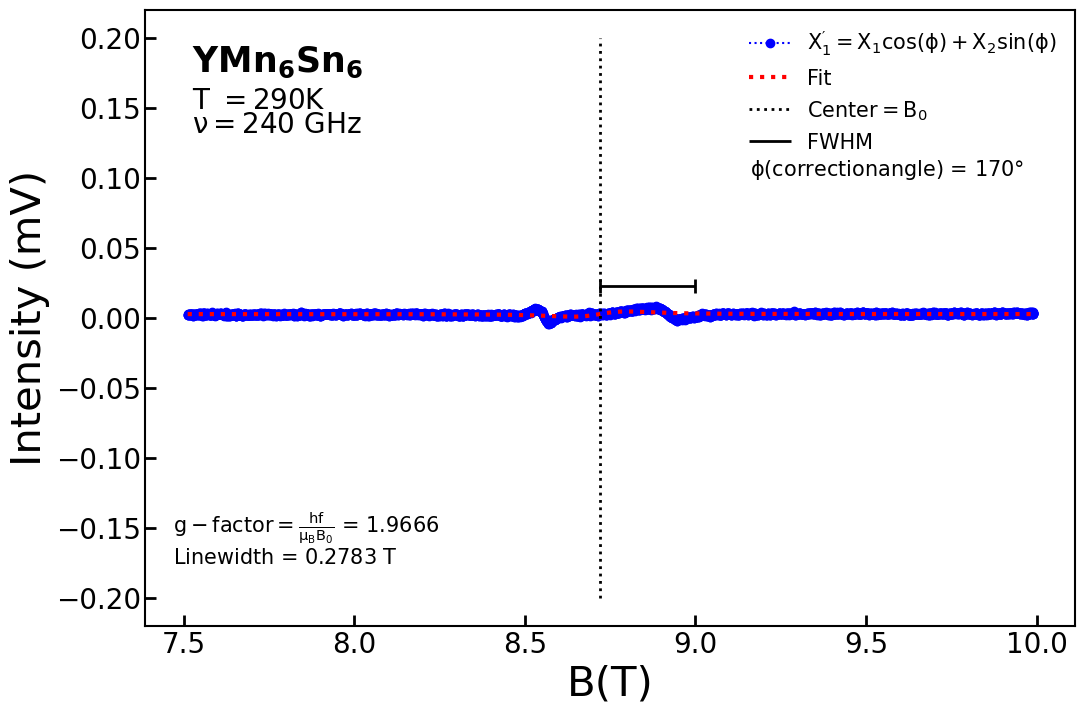

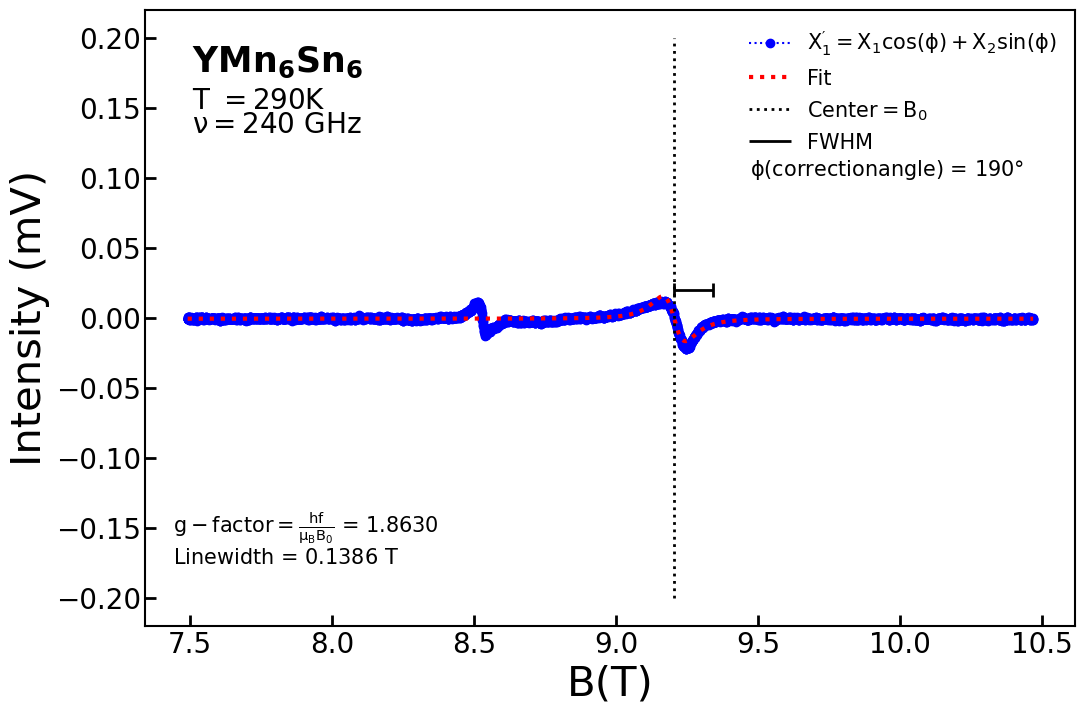

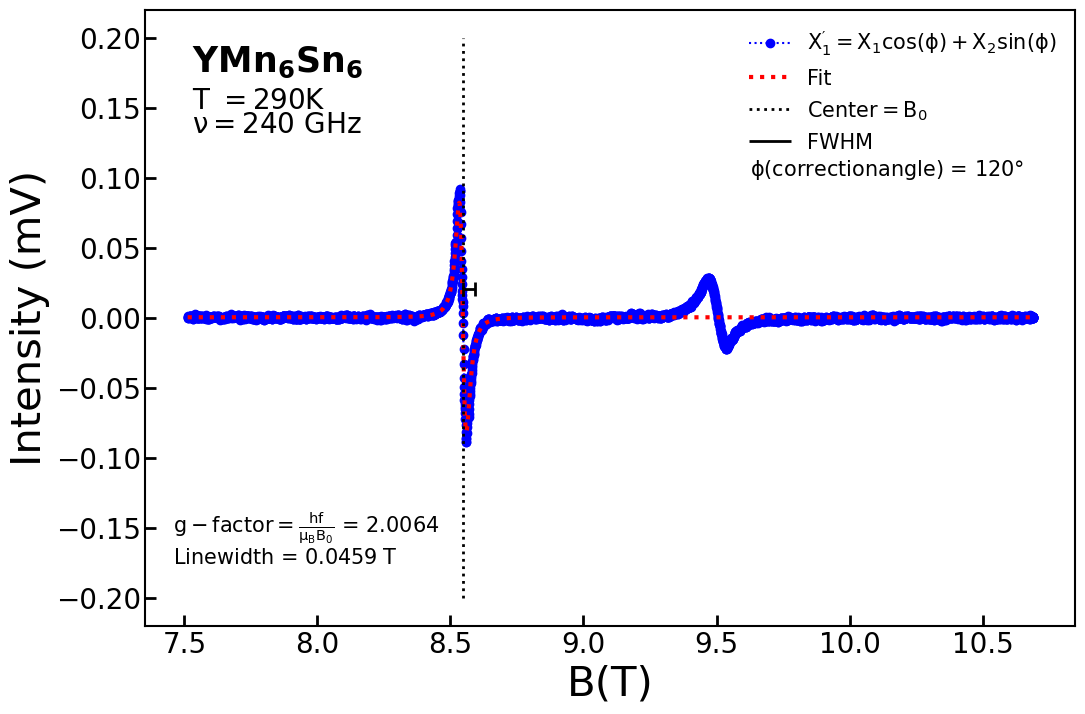

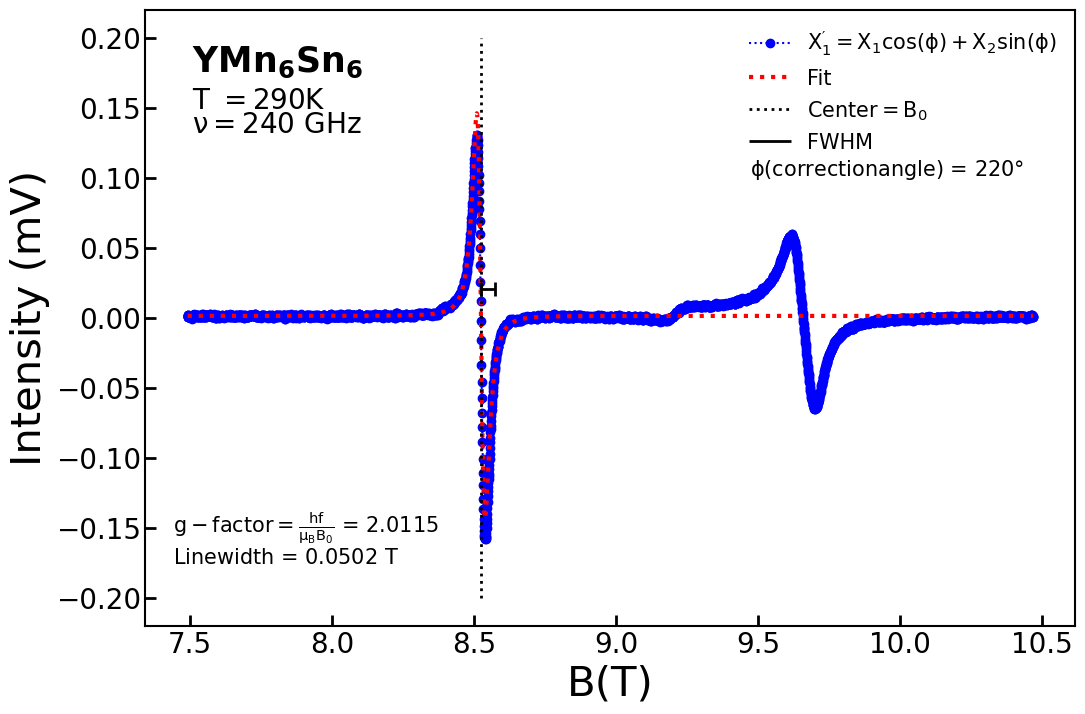

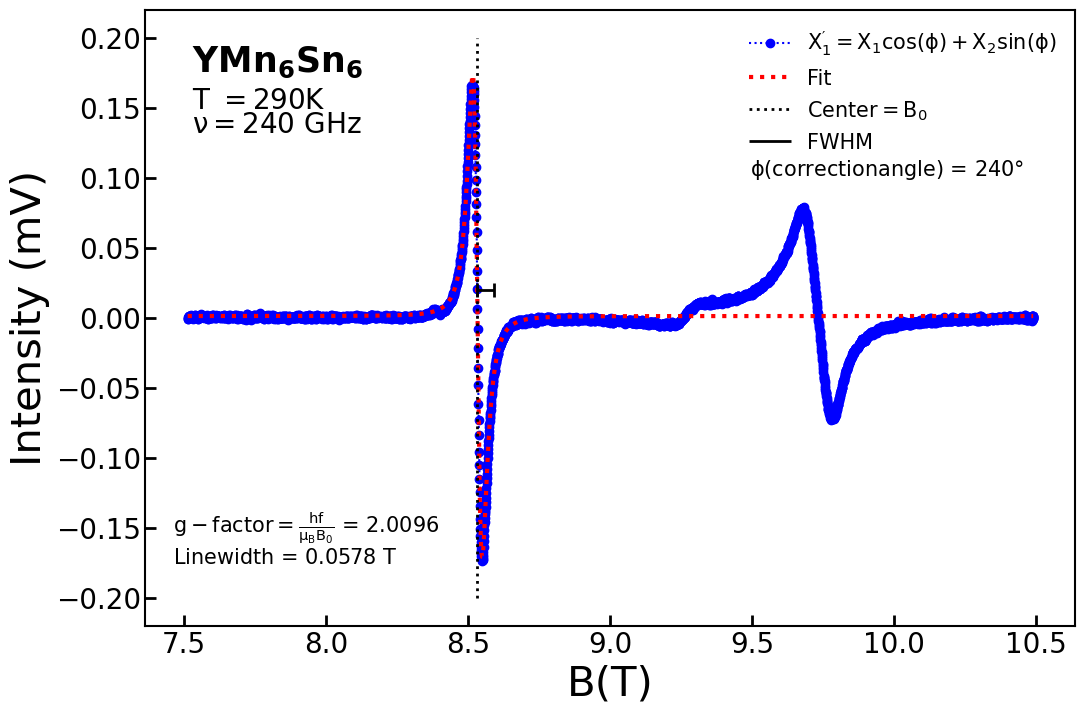

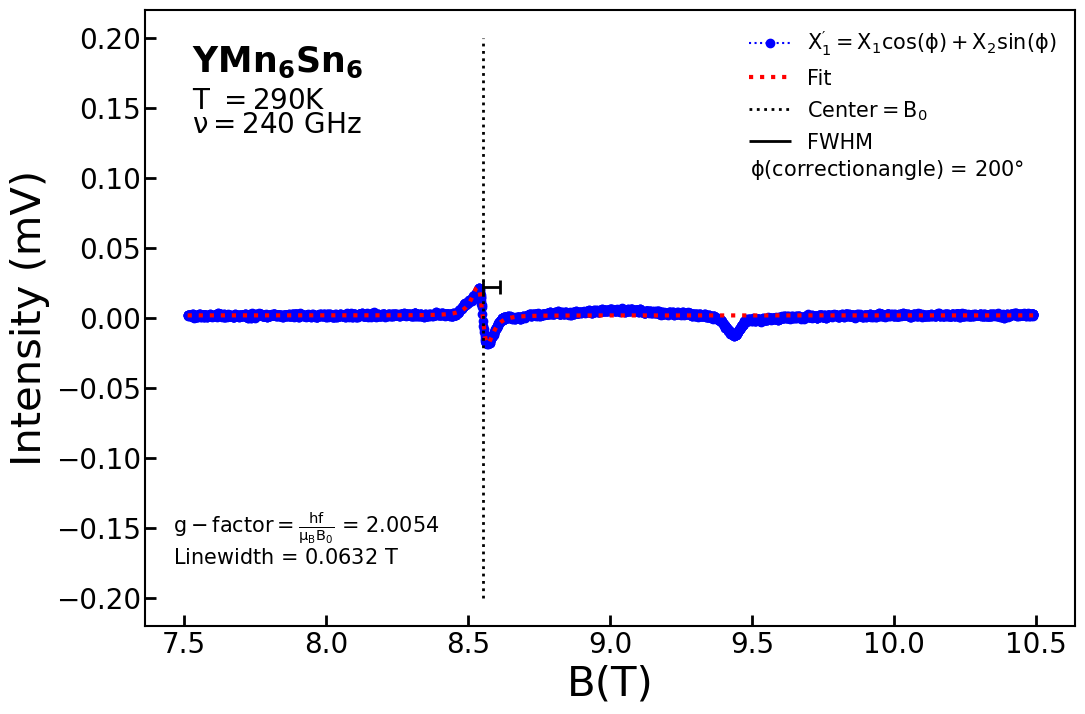

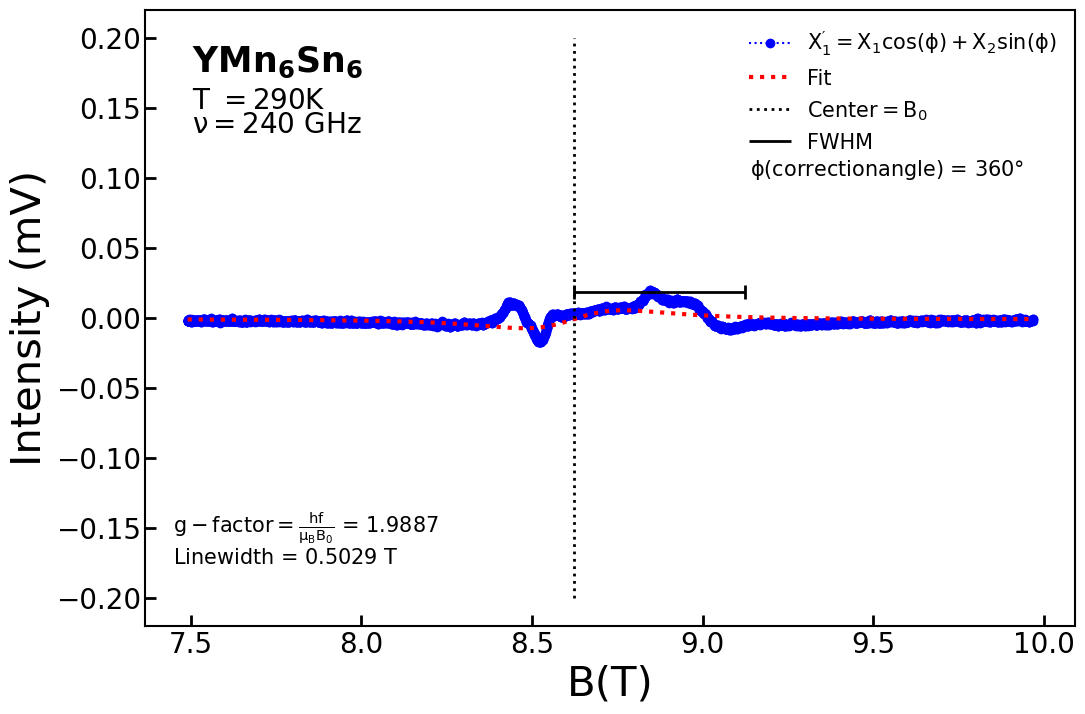

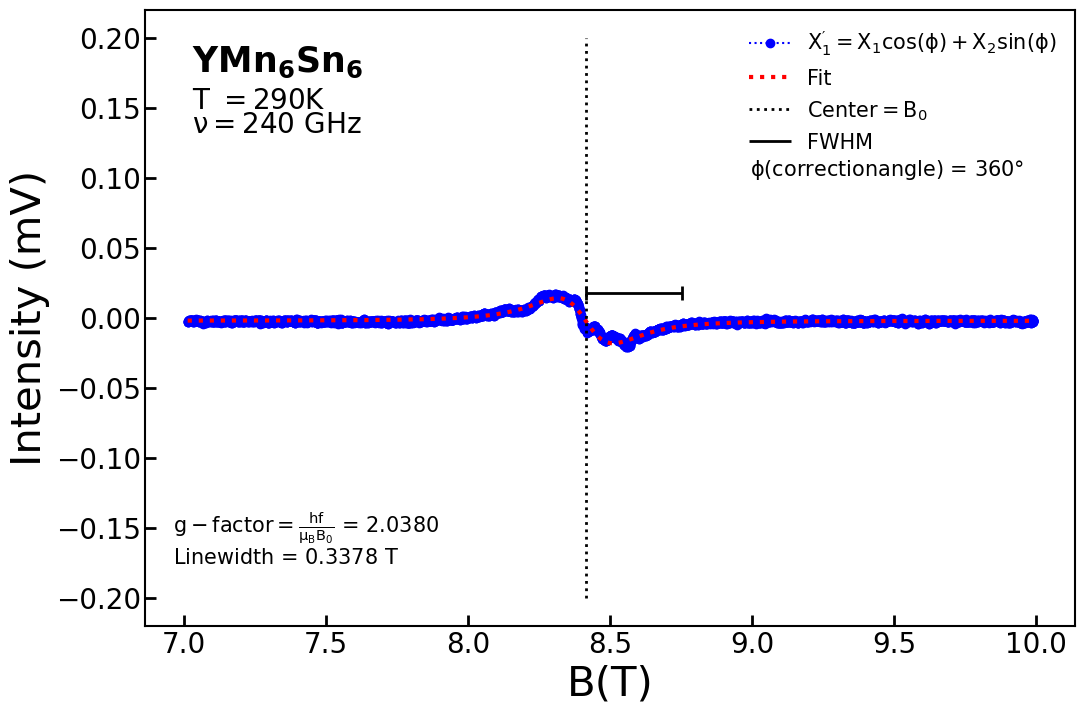

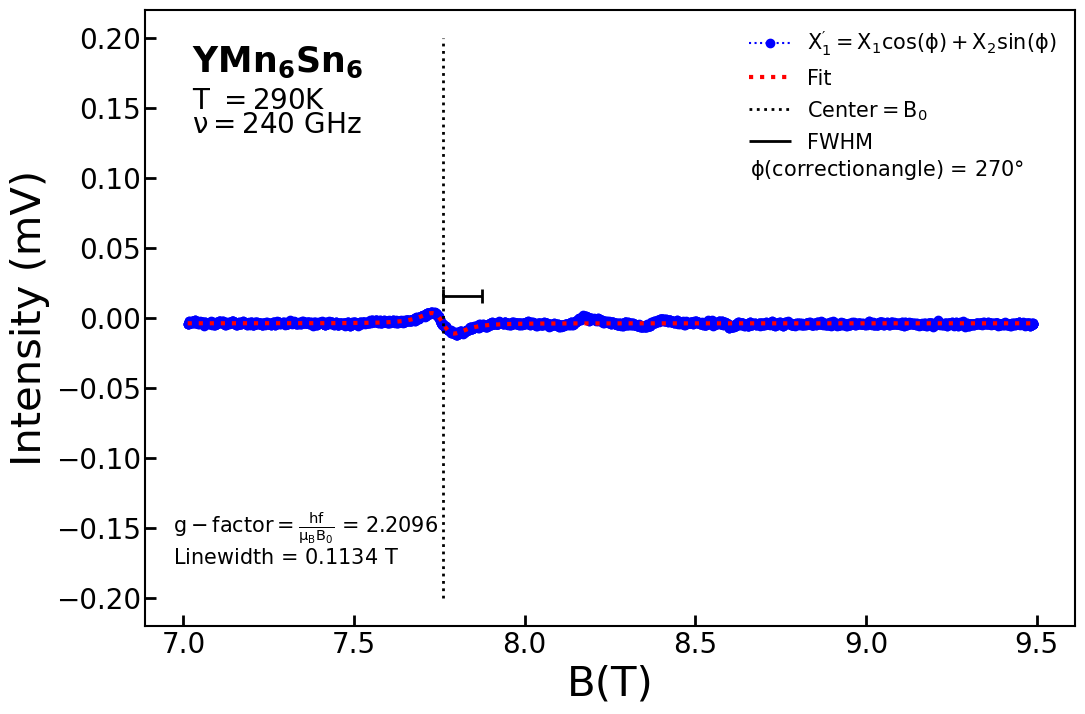

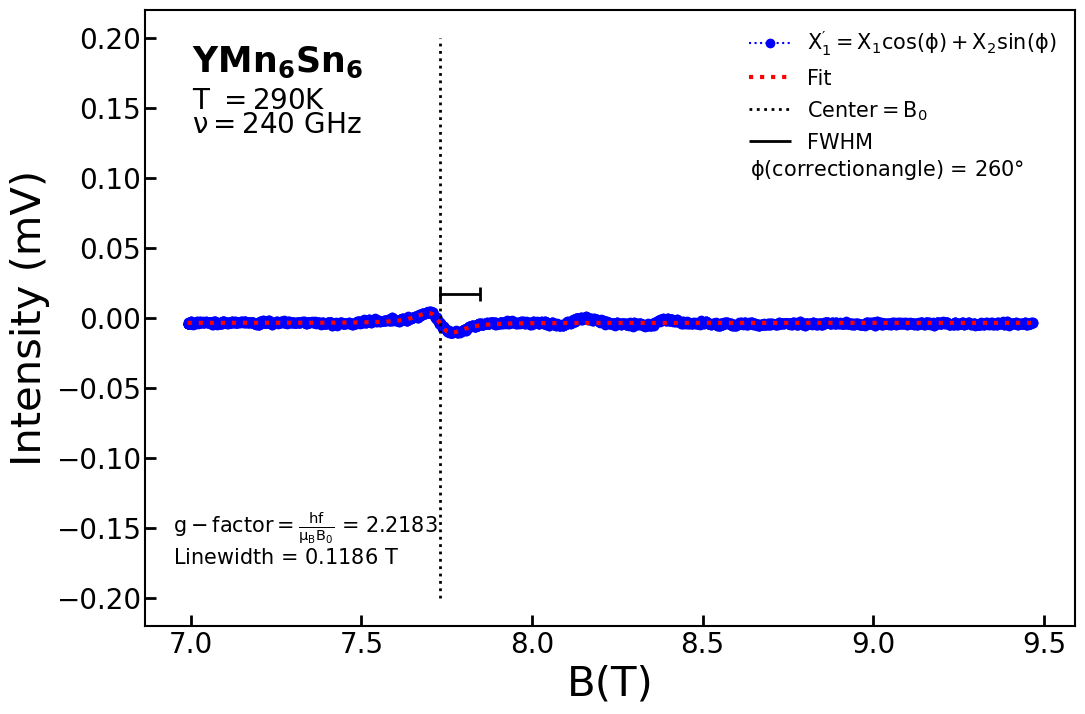

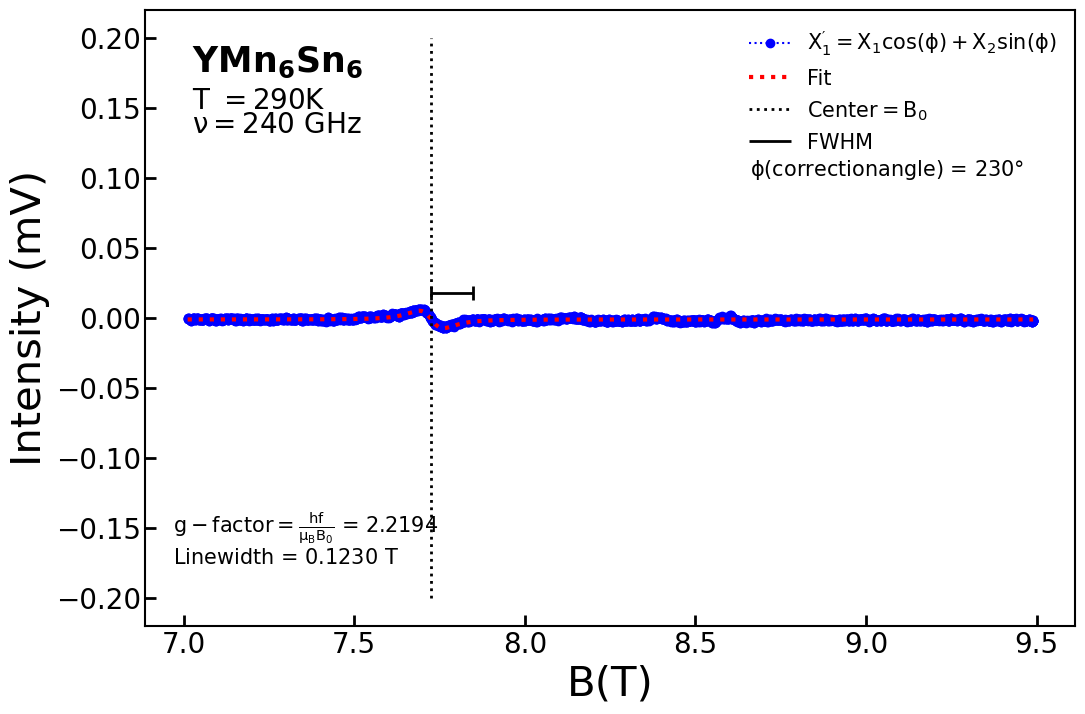

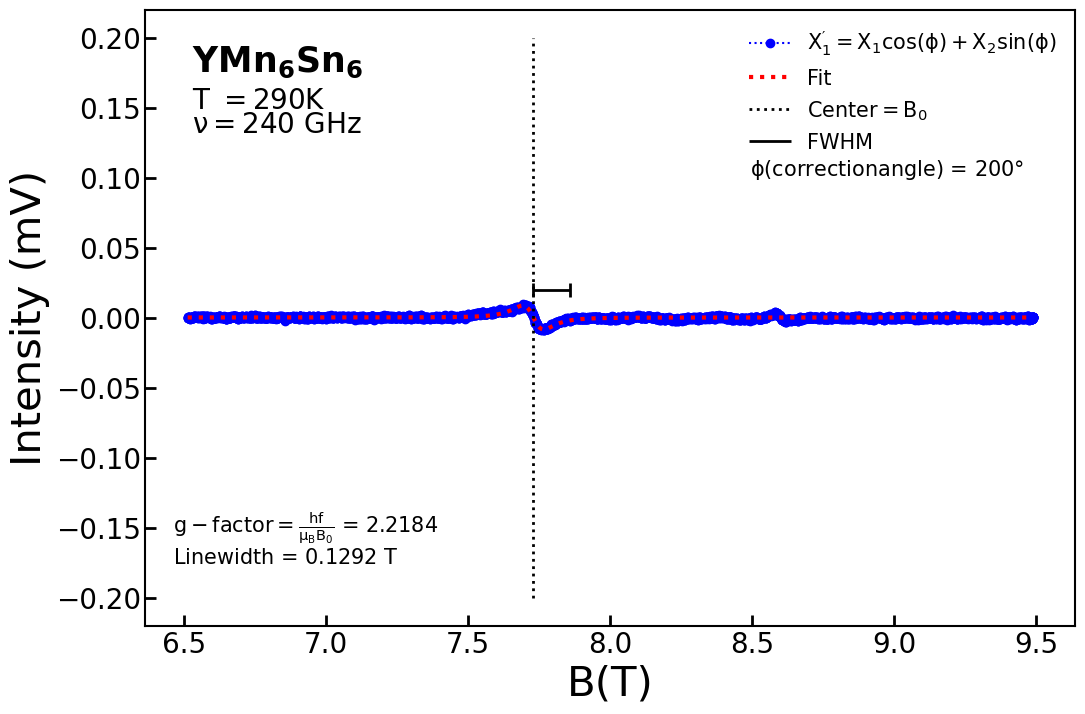

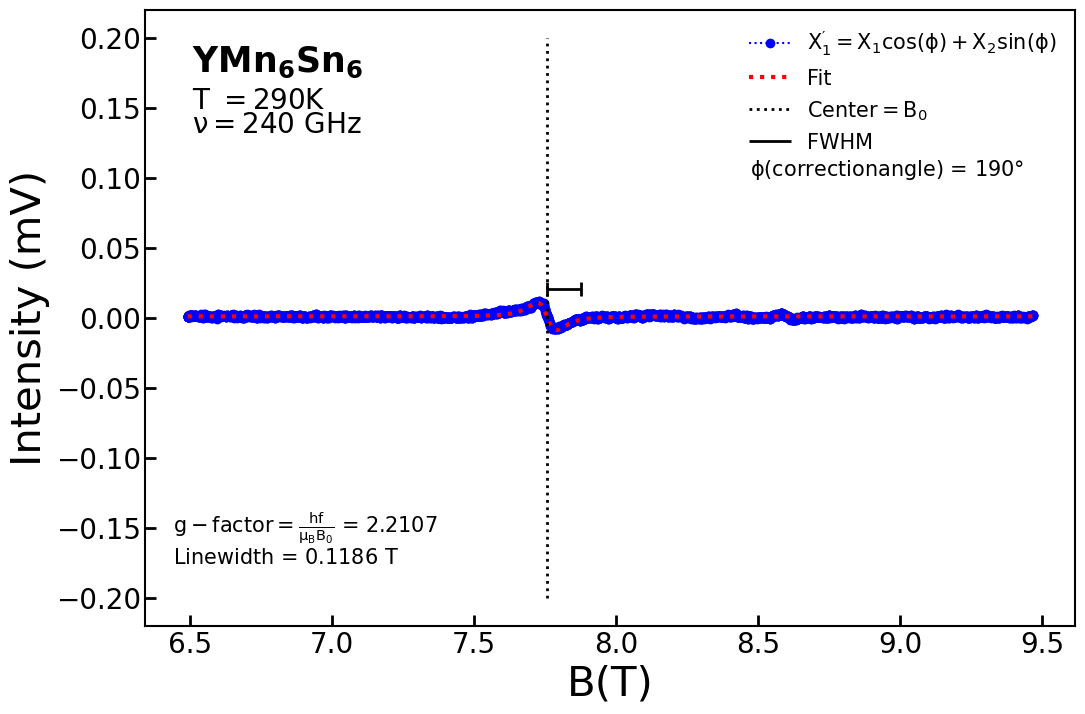

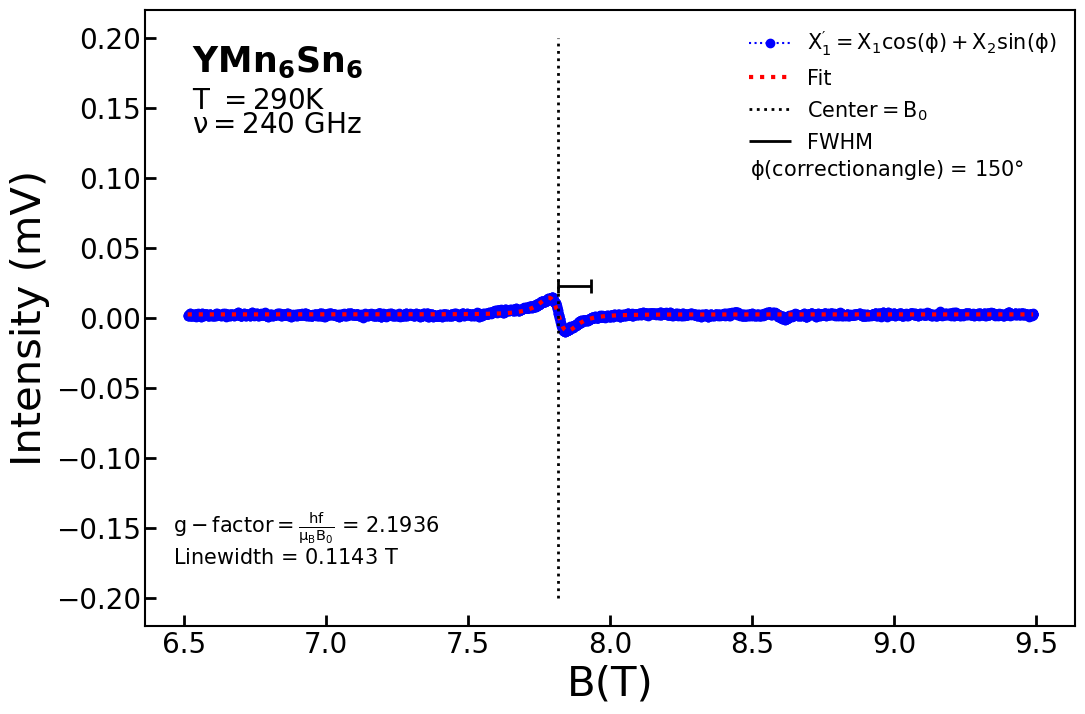

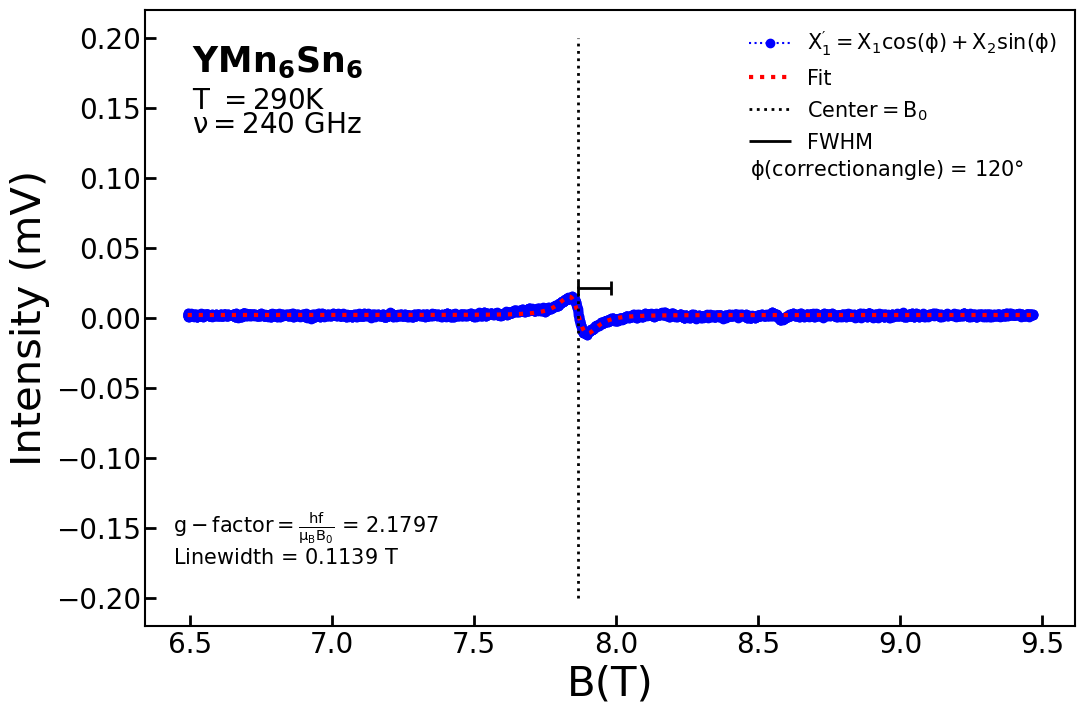

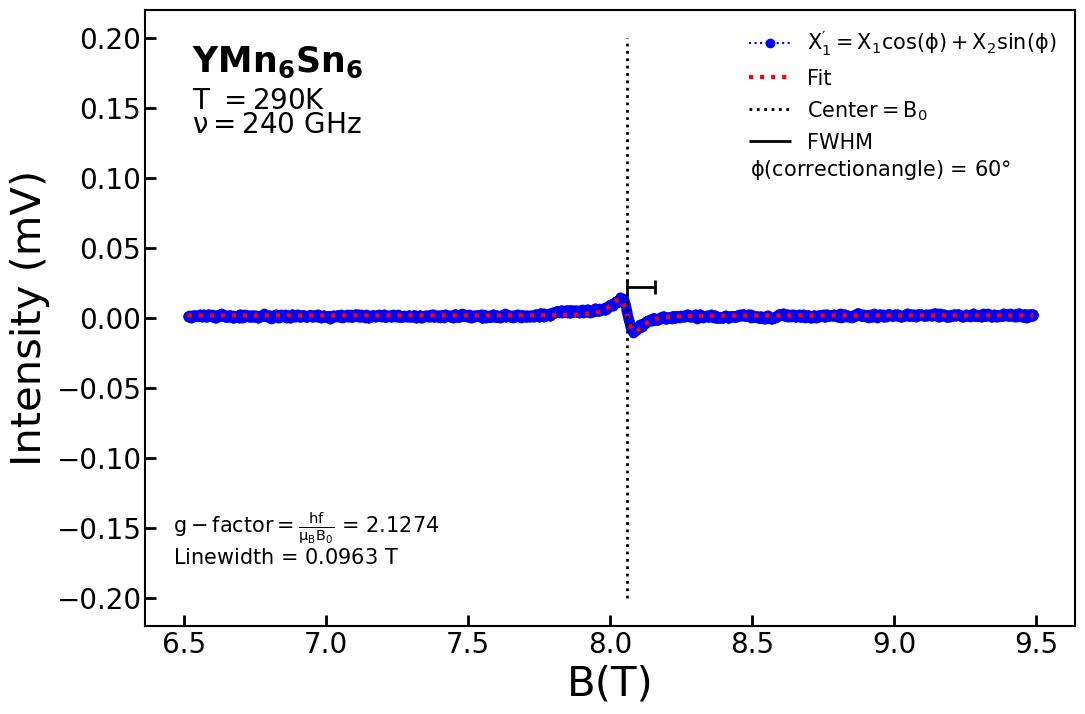

In [4]:
############## Create RAW data Figures For Each Temperature #####################
for i in datafiles:
    fig1,ax=plt.subplots()
    fig1.set_size_inches(12,8)
    fig1.subplots_adjust(hspace=.0)
    fig1.patch.set_facecolor('white')
    
    ax.plot(dict_data[i][0], dict_data[i][4], color="blue", linestyle="dotted", marker='o', label="$X_1'=X_1\cos(\phi)+X_2\sin(\phi)$")
    ax.plot(dict_data[i][5], dict_data[i][6], color="red", linestyle="dotted", linewidth=3, label="Fit")

    ax.annotate(r'$YMn_6Sn_6\ $',ha='left', xy=(0.05, 0.9),weight='bold',xycoords='axes fraction', fontsize=25)
    ax.annotate(r'$T\ = $'+str(dict_data[i][3]),ha='left', xy=(0.05, 0.84),xycoords='axes fraction', fontsize=20)
    ax.annotate(r'$\nu=240\ GHz$', ha='left', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=20, color='black')
    

    ax.annotate(r'$\phi (correction angle)$ = '+str(dict_data[i][9])+r'$\degree$',ha='left', xy=(0.65, 0.73),xycoords='axes fraction', fontsize=15)
    ax.annotate(r'$Linewidth$ = '+f"{dict_data[i][8]:.4f} T",ha='left', xy=(0.03,0.10),xycoords='axes fraction', fontsize=15)
    ax.annotate(r'$g-factor = \frac{hf}{\mu_BB_0}$ = '+f"{dict_data[i][7]:.4f}",ha='left', xy=(0.03,0.15),xycoords='axes fraction', fontsize=15)


    
    ax.vlines(x = dict_data[i][10],ymin=-0.2,ymax=0.2, color = 'black',linestyle="dotted",linewidth=2, label = '$Center=B_0$')
    ax.vlines(x = dict_data[i][10],ymin=dict_data[i][11]+0.015,ymax=dict_data[i][11]+0.025, color = 'black',linestyle="solid",linewidth=2)
    ax.vlines(x = dict_data[i][10]+dict_data[i][8],ymin=dict_data[i][11]+0.015,ymax=dict_data[i][11]+0.025, color = 'black',linestyle="solid",linewidth=2)



    ax.hlines(y = dict_data[i][11]+0.02, xmin= dict_data[i][10], xmax=(dict_data[i][10]+dict_data[i][8]), linewidth=2, linestyle="solid", color='black', label='FWHM')




    
    
    ax.legend(loc='upper right', prop={'size': 15}, frameon=False)
    props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
            
    #plt.title(label = r'$\mathrm{CrPS_s\ 240GHz\ EPR}$', fontsize = 32)
    ax.set_xlabel("B(T)", fontsize=30)
    ax.set_ylabel("Intensity (mV)",fontsize=30)
    #ax.set_ylim(-0.2,0.2)
    ax.tick_params(axis='both', which='major', labelsize=20)
    #plt.savefig("YMnS 240GHz Rotational ESR Fits "+i+".png", dpi=300)

In [5]:
def find_resonance_fields(data):
    B_field = data[0]  # Extract B field values
    X1_corrected = data[4]  # Extract corrected intensity
    peak_idx = np.argmax(X1_corrected)  # Find index of the peak intensity
    resonance_field = B_field[peak_idx]  # Corresponding magnetic field at the peak
    return resonance_field

# Extract resonance fields and map them to rotation angles
resonance_fields = []
for i, file_name in enumerate(datafiles):
    resonance_field = find_resonance_fields(dict_data[file_name])
    resonance_fields.append(resonance_field)

print (resonance_fields)

[8.88484905675742, 9.17370667942137, 8.535080368506957, 8.510675537795485, 8.512338180469643, 8.537929788784158, 8.845689505228451, 8.307719235051222, 7.727574953989374, 7.702389840246726, 7.695895136529859, 7.6924283930867015, 7.7294634042760855, 7.79598565476783, 7.84576709608045, 8.036464431060923]


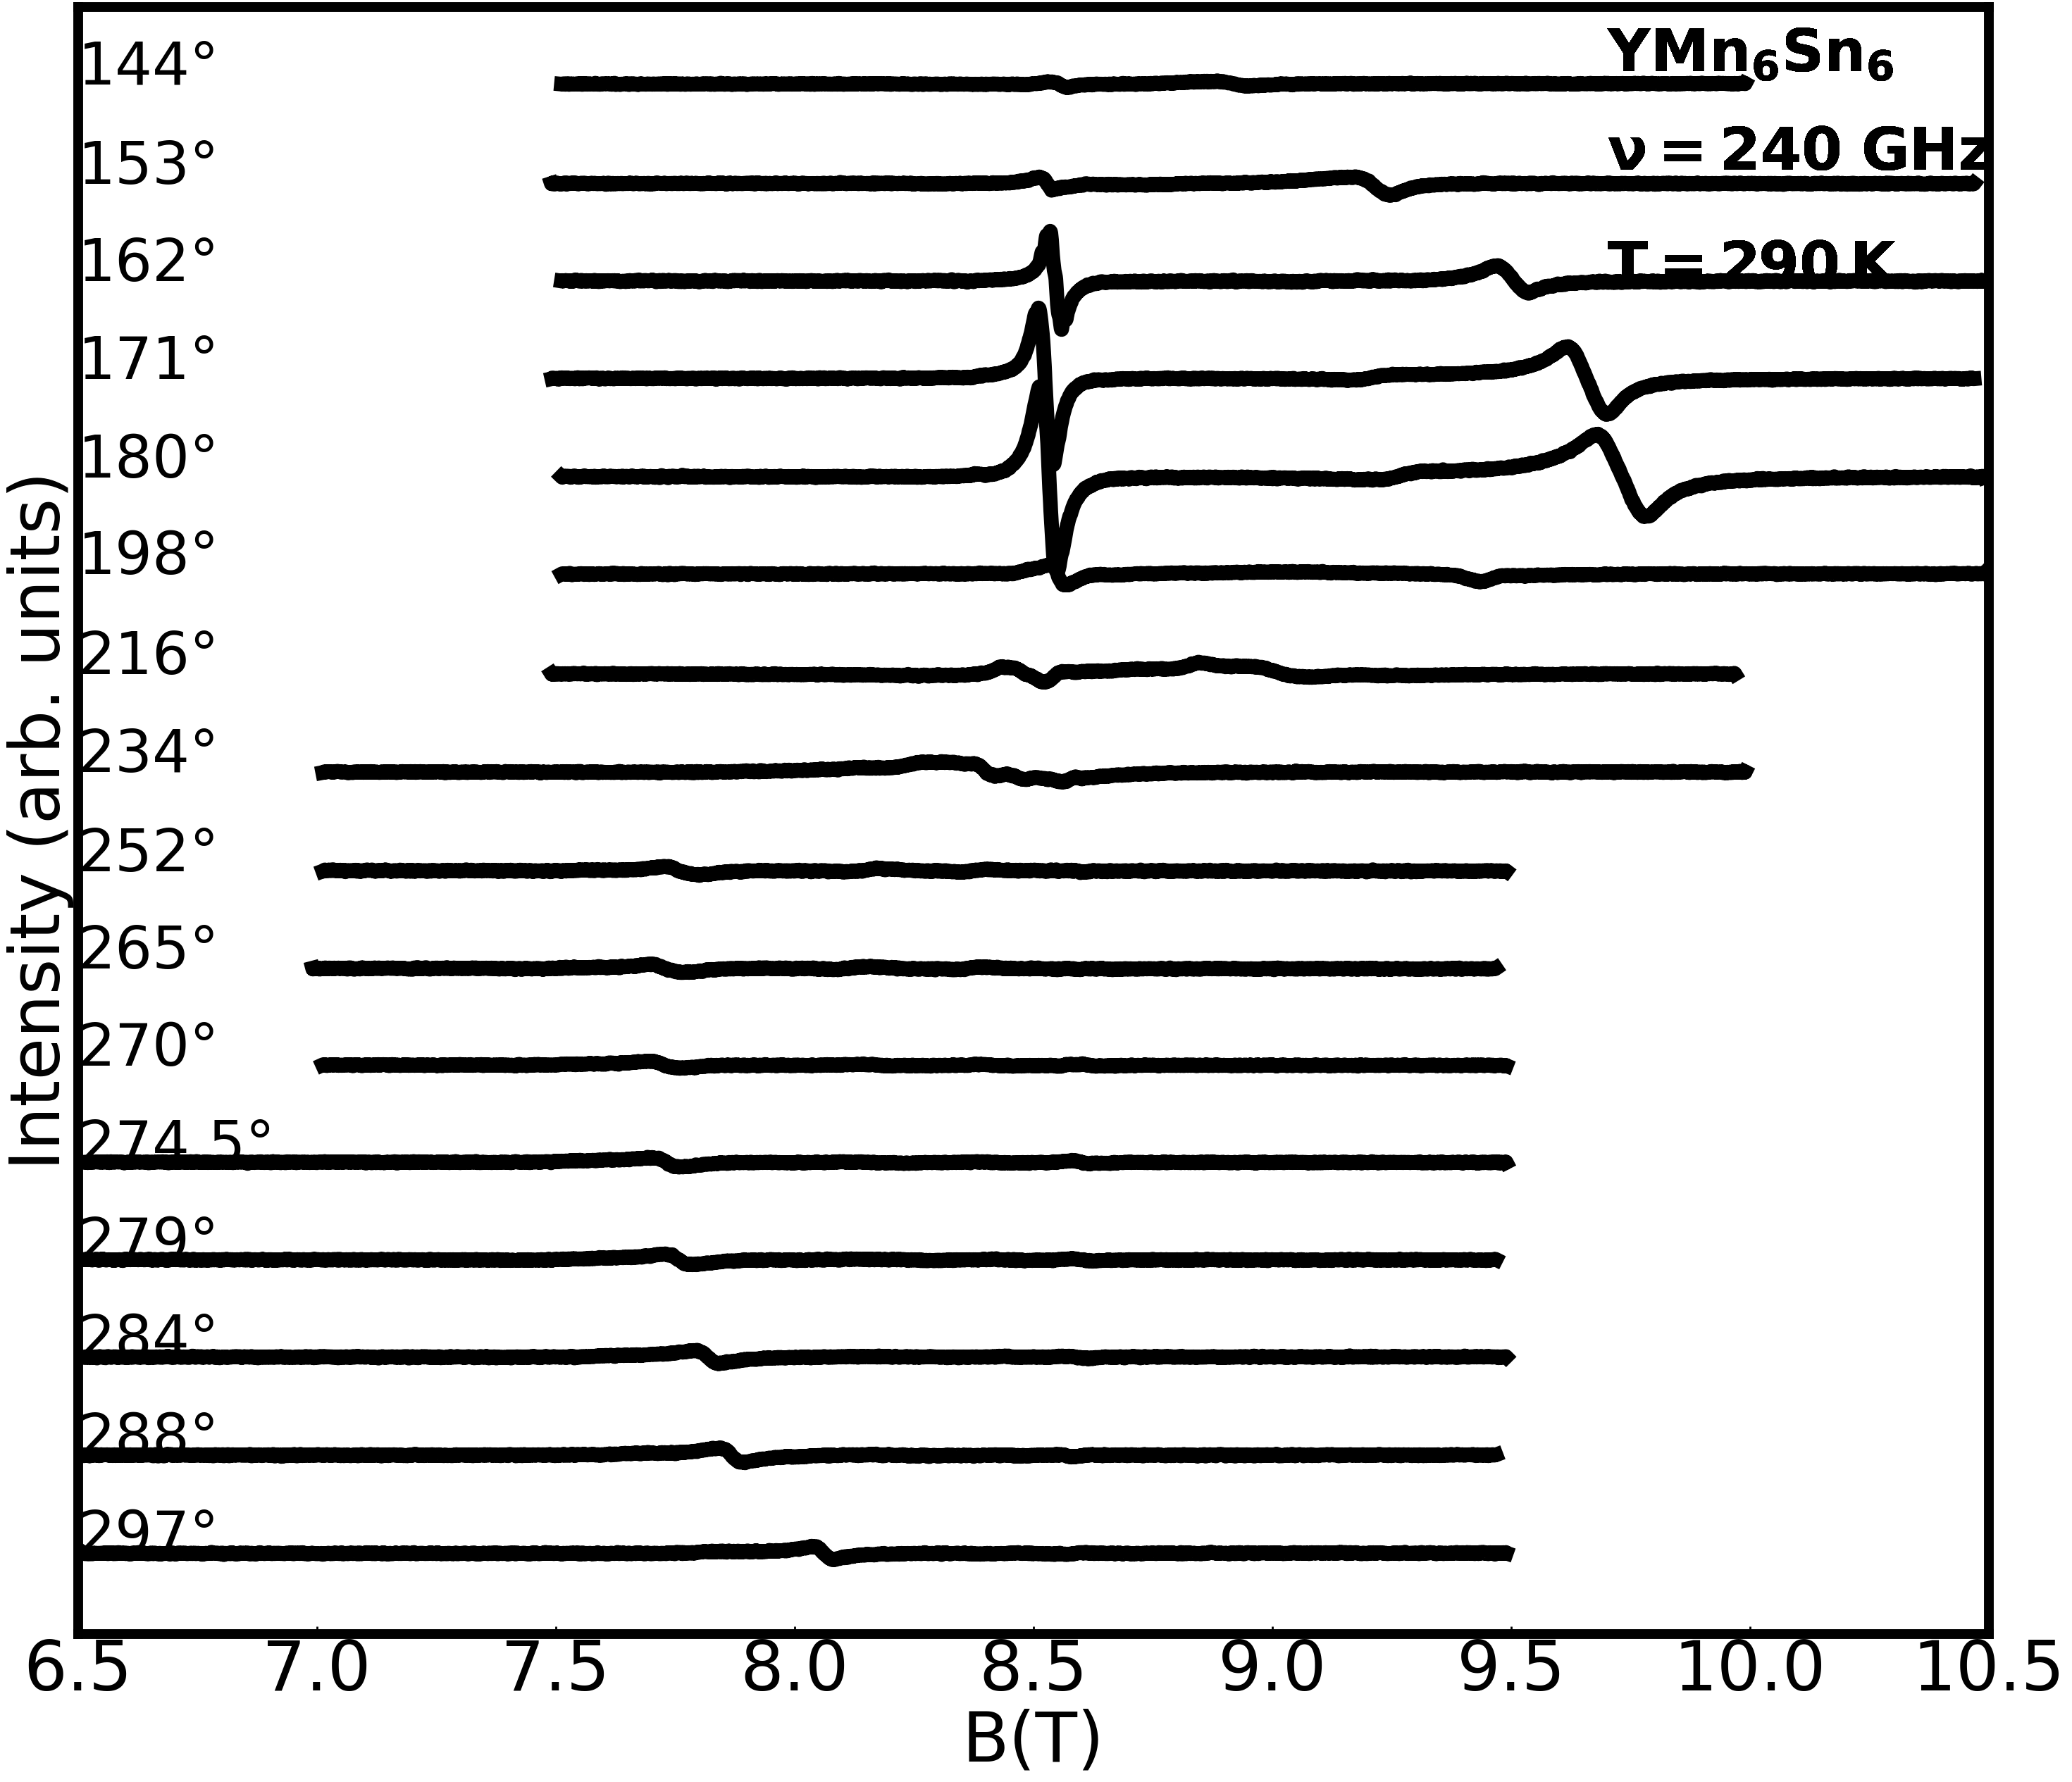

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Your existing code...
# Define temperatures for each dataset
rotations = [144,153,162,171,180,198,216,234,252,265,270,274.5,279,284,288,297]
# Define a custom colormap with grayscale gradient
custom_colors = [(i / (len(rotations) - 1), 'black') for i in range(len(rotations))] # Grayscale gradient
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colors)
# Plot data with gradient colors using the custom colormap
fig1, ax = plt.subplots()
fig1.set_size_inches(35, 30)
fig1.patch.set_facecolor('white') # White background
spacing = 0.18 # Adjust spacing between plots
for i, rotation in enumerate(rotations):
    ax.plot(dict_data[datafiles[i]][0], dict_data[datafiles[i]][4] - 0.05 - spacing * i, color=custom_cmap(i / len(rotations)), linestyle="solid", marker='o', markersize=1, linewidth=15)
    ax.annotate(f'{rotation}°', ha='left', xy=(6.5, dict_data[datafiles[i]][4][0] - 0.05 - spacing * i), xycoords='data', fontsize=60, color='black')
    ax.annotate(r'$YMn_6Sn_6$', ha='left', xy=(0.8, 0.96), weight='bold', xycoords='axes fraction', fontsize=60, color='black')
    ax.annotate(r'$\nu=240\ GHz$', ha='left', xy=(0.8, 0.9), weight='bold', xycoords='axes fraction', fontsize=60, color='black')
    ax.annotate(r'$T = 290 \, K$', xy=(0.84, 0.88), weight='bold', xycoords='axes fraction', xytext=(0.8, 0.83),ha='left', color='black', fontsize=60)
    ax.set_facecolor('white') # White background
    props = dict(boxstyle='round', facecolor='gray', alpha=1.5)
    ax.set_xlabel("B(T)", fontsize=70, color='black')
    ax.set_ylabel("Intensity (arb. units)", fontsize=70, color='black')
    ax.set_xlim(6.5, 10.5)
    ax.tick_params(axis='both', which='major', labelsize=70, colors='black')

# Increase axis line thickness
ax.spines['bottom'].set_linewidth(10)  # X-axis
ax.spines['left'].set_linewidth(10)    # Y-axis
ax.spines['top'].set_linewidth(10)     # Top border (optional)
ax.spines['right'].set_linewidth(10)   # Right border (optional)

# Remove y-axis ticks and labels
ax.set_yticks([]) # This removes the y-axis ticks and labels
plt.savefig("YMnSn 240GHz Rotational Waterfall Plot 2.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

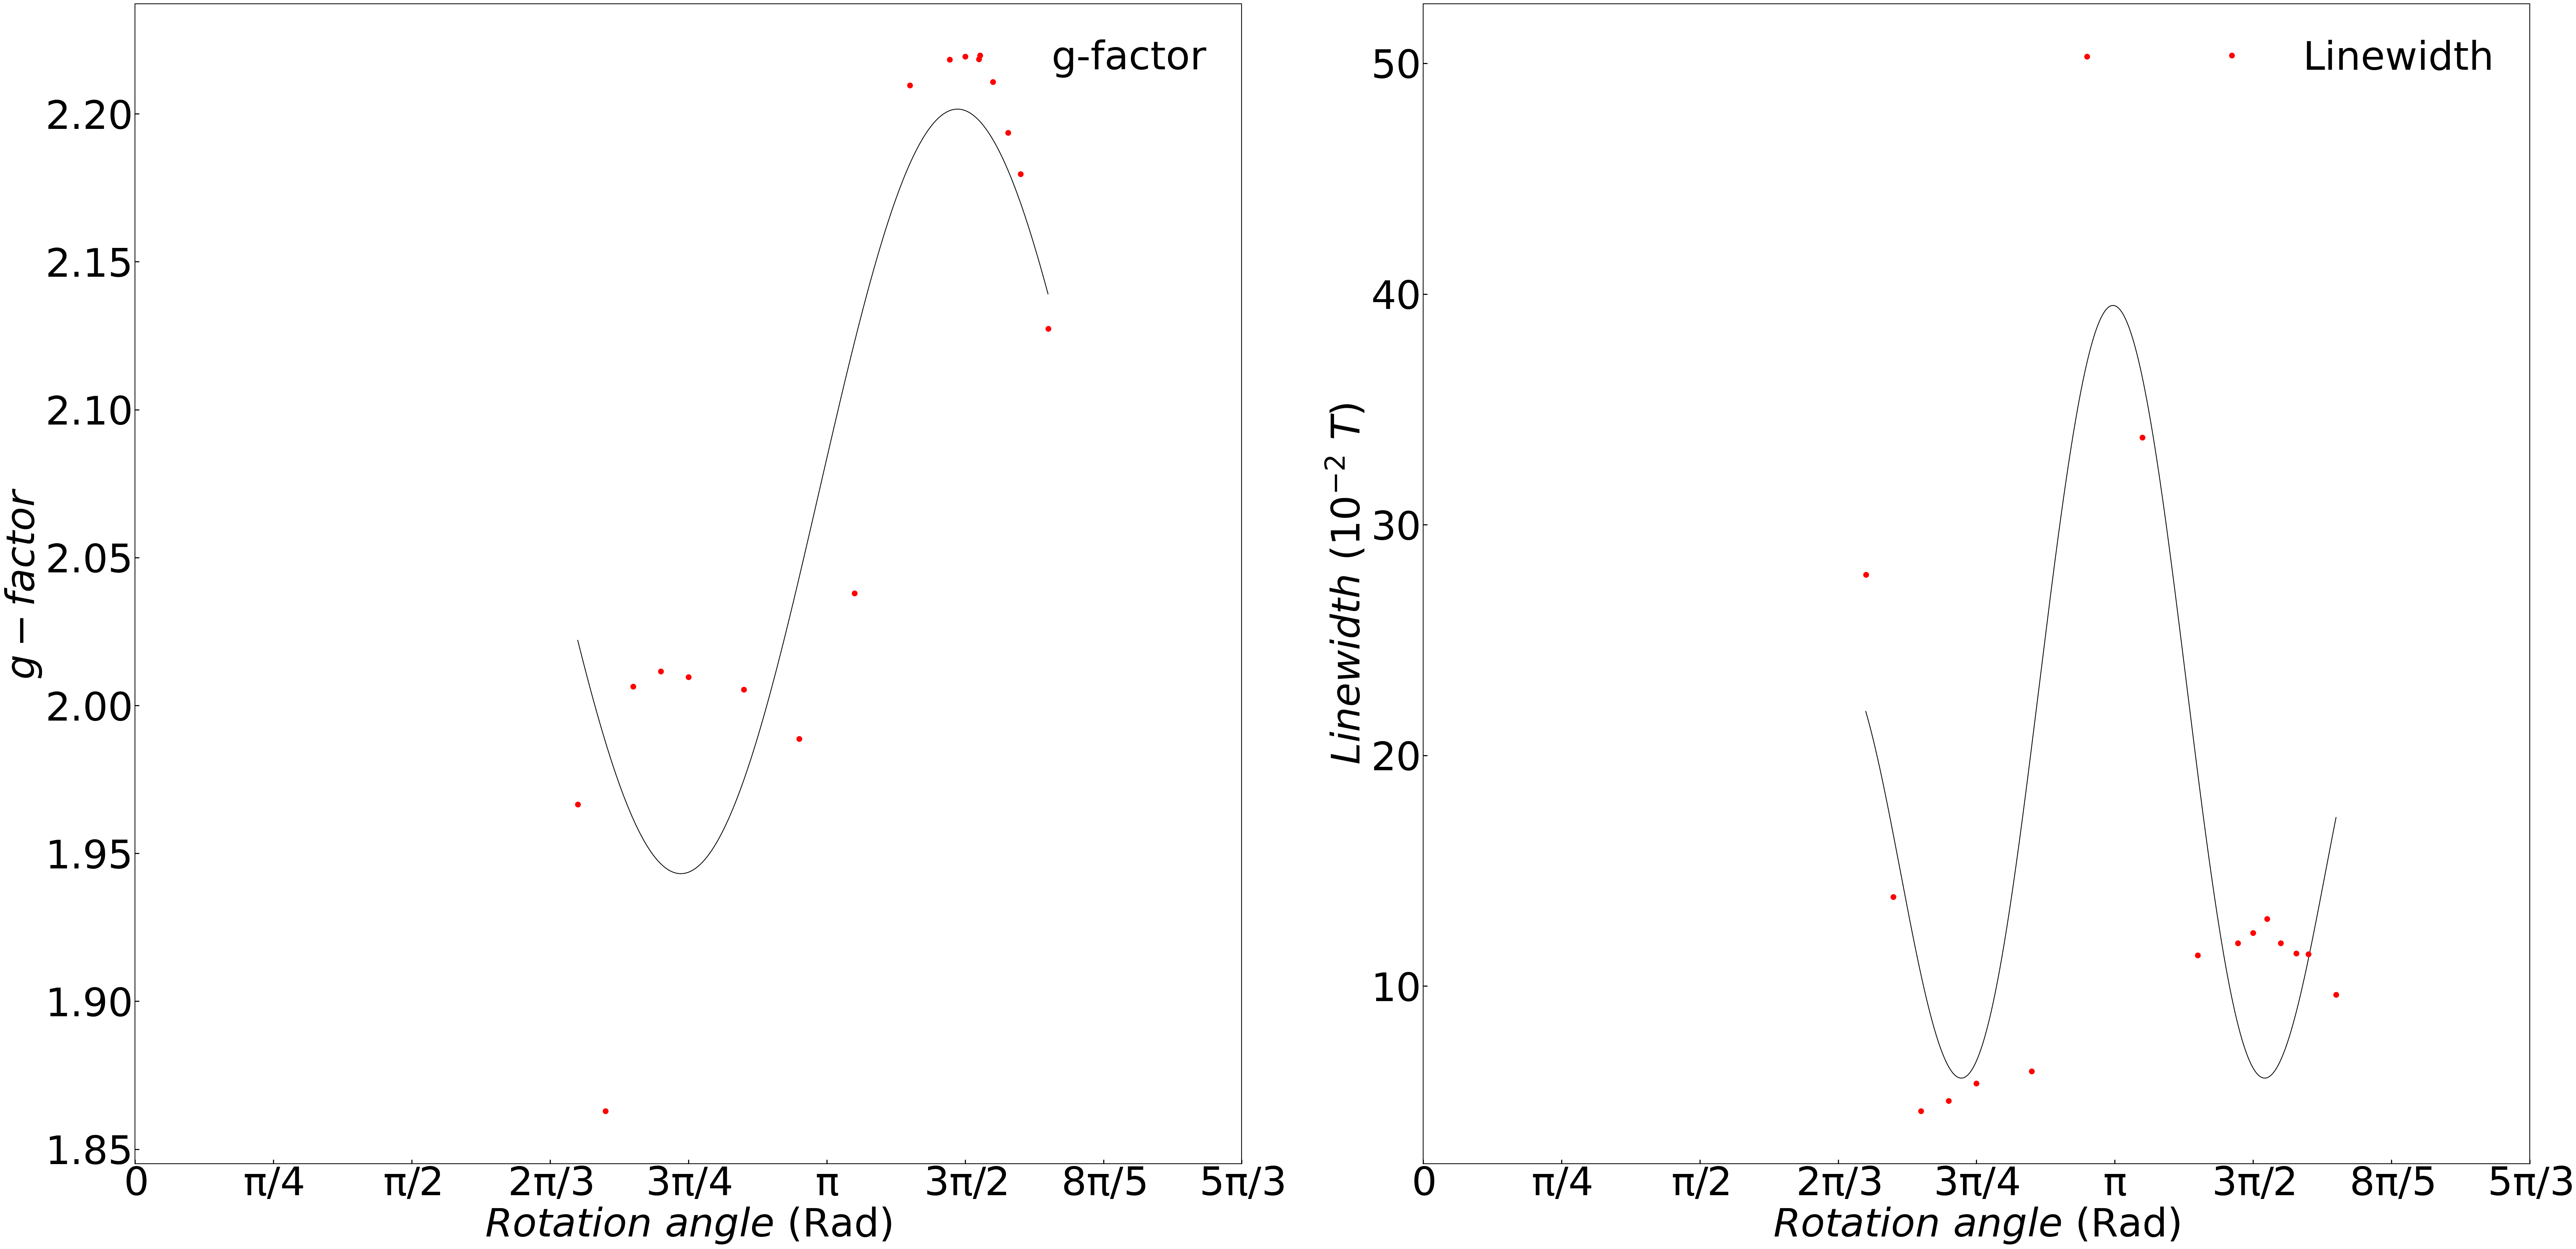

In [7]:
def W(x, A,B,s,C):
    w = (A*(np.cos(x-s)**2+1)+B*(np.cos(x-s)**4)+C)
    return w
              
Wparameters,_=curve_fit(W,rotations_radians,linewidths)
x_line_w = np.arange(min(rotations_radians),max(rotations_radians),0.0015)
dy_line_w = W(x_line_w, Wparameters[0],Wparameters[1],Wparameters[2],Wparameters[3])

def U(x, A,B,s):
    u = (A*(np.cos(x-s)**2-1)+B)
    return u
              
Uparameters,_=curve_fit(U,rotations_radians,gfactors)
x_line_u = np.arange(min(rotations_radians),max(rotations_radians),0.0015)
dy_line_u = U(x_line_u, Uparameters[0],Uparameters[1],Uparameters[2])

labels = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$2\pi/3$', r'$3\pi/4$' , r'$\pi$', r'$3\pi/2$', r'$8\pi/5$',r'$5\pi/3$']

# Generate tick locations corresponding to the 8 labels
tick_locations = np.linspace(0, 2 * np.pi, len(labels))

fig1, ((ax1, ax2)) = plt.subplots(1, 2)
fig1.subplots_adjust(hspace=.0)
fig1.patch.set_facecolor('white')
fig1.set_size_inches(70, 35)

# Plot for g-factors
ax1.set_xlabel(r'$\it{Rotation\ angle}\  $(Rad)', fontsize=75)
ax1.set_ylabel(r'$\it{g-factor}$', fontsize=75)
ax1.plot(x_line_u, dy_line_u, color='black')
ax1.plot(rotations_radians, gfactors, color='red', marker="o", markersize=10, markerfacecolor='Red', linestyle='None', label="g-factor")
ax1.legend(frameon=False, loc='upper right')

# Plot for Linewidth
ax2.set_xlabel(r'$\it{Rotation\ angle}\  $(Rad)', fontsize=75)
ax2.set_ylabel(r'$\it{Linewidth}\ (10^{-2}\ T)$', fontsize=75)
ax2.plot(x_line_w, np.array(dy_line_w) * 10**2, color='black')
ax2.plot(rotations_radians, np.array(linewidths) * 10**2, color='red', marker="o", markersize=10, markerfacecolor='Red', linestyle='None', label="Linewidth")
ax2.legend(frameon=False, loc='upper right')

# Set ticks and labels for ax1
ax1.set_xticks(tick_locations)
ax1.set_xticklabels(labels)

# Set ticks and labels for ax2
ax2.set_xticks(tick_locations)
ax2.set_xticklabels(labels)

plt.tight_layout()
#plt.savefig("YMnSn 240 Rotation Parameter Plots.png")
plt.show()

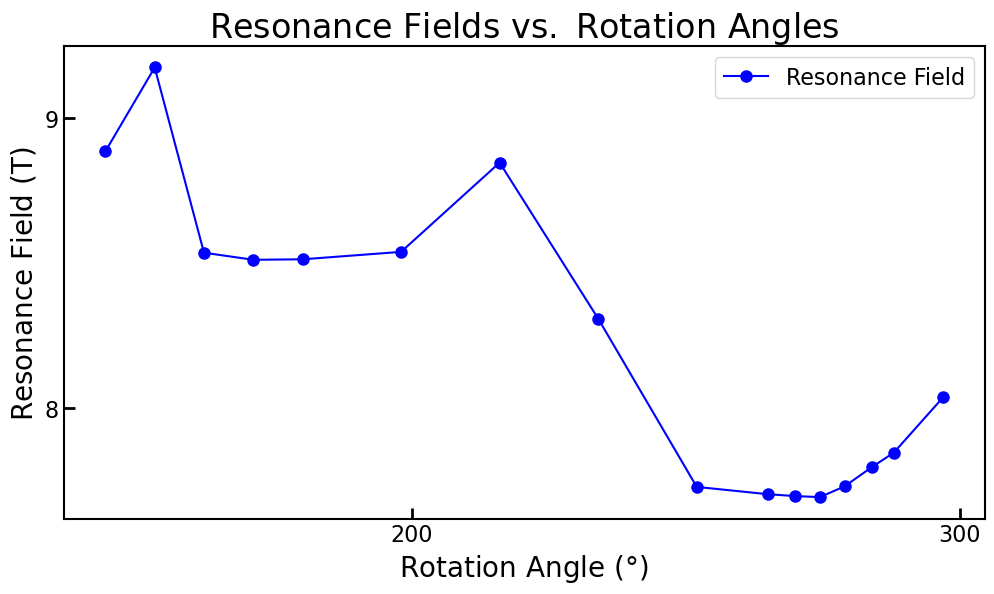

[8.88484905675742, 9.17370667942137, 8.535080368506957, 8.510675537795485, 8.512338180469643, 8.537929788784158, 8.845689505228451, 8.307719235051222, 7.727574953989374, 7.702389840246726, 7.695895136529859, 7.6924283930867015, 7.7294634042760855, 7.79598565476783, 7.84576709608045, 8.036464431060923]
[144, 153, 162, 171, 180, 198, 216, 234, 252, 265, 270, 274.5, 279, 284, 288, 297]


In [8]:
def find_resonance_fields(data):
    B_field = data[0]  # Extract B field values
    X1_corrected = data[4]  # Extract corrected intensity
    peak_idx = np.argmax(X1_corrected)  # Find index of the peak intensity
    resonance_field = B_field[peak_idx]  # Corresponding magnetic field at the peak
    return resonance_field

# Extract resonance fields and map them to rotation angles
resonance_fields = []
for i, file_name in enumerate(datafiles):
    resonance_field = find_resonance_fields(dict_data[file_name])
    resonance_fields.append(resonance_field)

# Plot resonance fields as a function of rotation angles
plt.figure(figsize=(12, 8))
plt.plot(rotations, resonance_fields, 'o-', color='blue', markersize=8, label='Resonance Field')
plt.xlabel(r'$\mathrm{Rotation\ Angle\ (°)}$', fontsize=20)
plt.ylabel(r'$\mathrm{Resonance\ Field\ (T)}$', fontsize=20)
plt.title(r'$\mathrm{Resonance\ Fields\ vs.\ Rotation\ Angles}$', fontsize=24)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.legend(fontsize=16)
plt.tight_layout()
#plt.savefig("YMnSn_Resonance_Fields_vs_Rotation_Angles.png", dpi=300)
plt.show()
print (resonance_fields)
print (rotations)

Fitted Parameters:
A = 0.4427
Phi (phase shift) = 1.0676 degrees
B = 8.2782


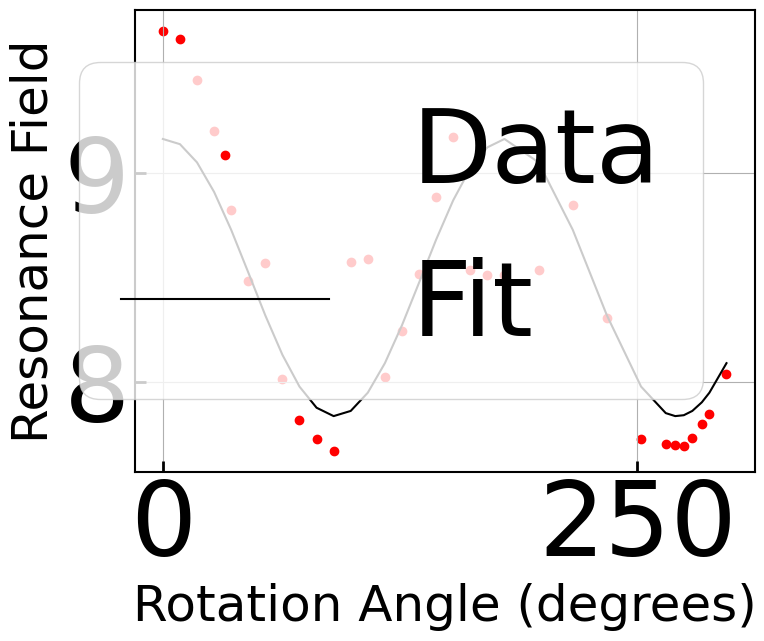

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Data
resonance_fields = [9.682347316881001, 9.642017145777263, 9.444195623460924, 9.202285819948257,
                    8.823755518280622, 8.483945358092457, 8.56858356465433, 8.012201841731764,
                    7.819712294248432, 7.727209241187028, 7.670889984825133, 8.575219440066512,
                    8.587511639530215, 8.022241804907164, 8.24388824837261, 8.51731631312792,
                    8.88484905675742, 9.17370667942137, 8.535080368506957, 8.510675537795485,
                    8.512338180469643, 8.537929788784158, 8.845689505228451, 8.307719235051222,
                    7.727574953989374, 7.702389840246726, 7.695895136529859, 7.6924283930867015,
                    7.7294634042760855, 7.79598565476783, 7.84576709608045, 8.036464431060923]

rotations = [0, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135,
             144, 153, 162, 171, 180, 198, 216, 234, 252, 265, 270, 274.5, 279,
             284, 288, 297]

# Convert angles to radians
rotations_rad = np.radians(rotations)

# Model function
def resonance_field(theta, A, phi, B):
    return A * (3 * np.cos(theta - phi)**2 - 1) + B

# Initial guesses for parameters: A, phi (in radians), B
initial_guesses = [1, 0, 8]

# Curve fitting
params, params_covariance = curve_fit(resonance_field, rotations_rad, resonance_fields, p0=initial_guesses)

# Extract fitted parameters
A_fit, phi_fit, B_fit = params

# Generate fitted data for plotting
fitted_fields = resonance_field(rotations_rad, A_fit, phi_fit, B_fit)

# Print fitted parameters
print(f"Fitted Parameters:")
print(f"A = {A_fit:.4f}")
print(f"Phi (phase shift) = {np.degrees(phi_fit):.4f} degrees")
print(f"B = {B_fit:.4f}")

# Plot data and fit
plt.figure(figsize=(8, 6))
plt.scatter(rotations, resonance_fields, label="Data", color="red")
plt.plot(rotations, fitted_fields, label="Fit", color="black")
plt.xlabel("Rotation Angle (degrees)")
plt.ylabel("Resonance Field")
#plt.title("Fitting Resonance Field to Angular Dependence")
plt.legend()
plt.grid()
plt.show()